In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torch.nn as nn
import torchgeometry as tgm
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import torch.nn.functional as F
import numpy as np
from ConvWass2D import ConvolutionalWasserstein2D
import torchvision
from torchvision import transforms
from utils import d, make_K_slow, make_K, make_K_3D, multiply_reshape, unravel_index, normalize_K, normalize_im
from utils import show_masks_on_image, keypoints_to_input_masks, keypoints_to_output_masks, mapped_accuracy, show_image, box_around_point

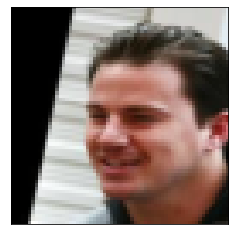

In [2]:
torch.manual_seed(0)
def transform(inp):
    main_transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor()],
    )
    inp = main_transform(inp)
    inp = inp + 1e-4
    inp = inp / torch.sum(torch.abs(inp))
    return inp
ds = torchvision.datasets.CelebA("/mnt/home/hlawrence/ceph/datasets/celeba", split='train', transform=transform, target_type="landmarks")
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)
for x, y in dl:
    break
show_image(x[1])
        
        


In [3]:
landmark = y[0]
landmarks_labels = ["left eye", "right eye", "nose", "left mouth", "right mouth"]
numim = 2
numdim = 2
keypoints = torch.zeros(len(landmarks_labels), numim, numdim)
H = 218
W = 178
out_size = 64
landmark_mask = torch.zeros(len(landmarks_labels), out_size, out_size)
for i, idx in enumerate(np.arange(0, len(landmarks_labels)*2, 2)):
    x_coord, y_coord = landmark[idx+1], landmark[idx]
    x_coord = torch.round(x_coord/H*out_size).int().item()
    y_coord = torch.round(y_coord/W*out_size).int().item()
    keypoints[i, 0, :] = torch.tensor([x_coord, y_coord])
    landmark_mask[i, x_coord, y_coord] = 1
keypoints = keypoints.long()

def get_img_landmarks(y, H=218, W=178, out_size=64):
    numim = y.shape[0]
    numdim = 2
    numlandmarks = int(y.shape[1] / 2)
    keypoints = torch.zeros(numlandmarks, numim, numdim).long()
    lminds = np.arange(0, numlandmarks*2, 2)
    for i, idx in enumerate(lminds):
        keypoints[i, :, 0] = torch.round(y[:, idx+1]/H*out_size).int() 
        keypoints[i, :, 1] = torch.round(y[:, idx]/W*out_size).int() 
    return keypoints.long()
keypoints = get_img_landmarks(y)

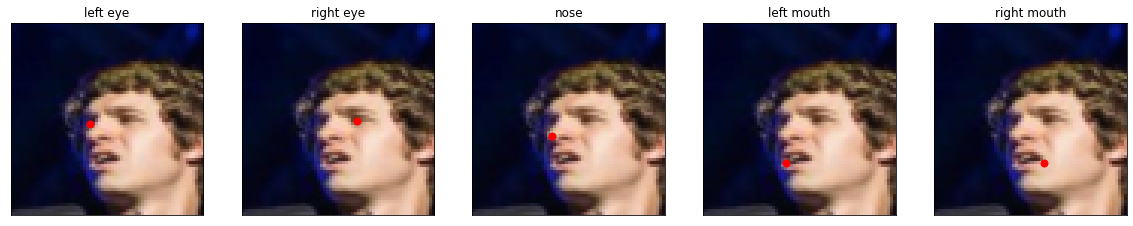

In [68]:
imind = 7 #18
img = x[imind]
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
base_color = torch.max(img.view(3, -1), dim=-1)[0][0]
for i in range(5):
    img = x[imind].clone()
    img[:, keypoints[i, imind, 0], keypoints[i, imind, 1]] = base_color
    #img[:, landmark_mask[i] > 0] = base_color
    show_image(img, ax[i])
    ax[i].plot(keypoints[i, imind, 1], keypoints[i, imind, 0], marker='o', color='red', markersize=7)
    ax[i].set_title(landmarks_labels[i])
plt.show()

0


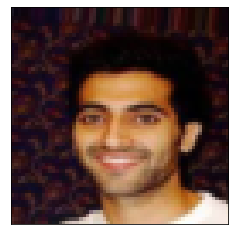

1


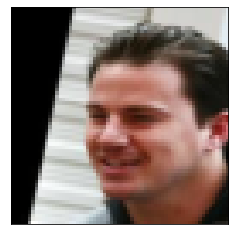

2


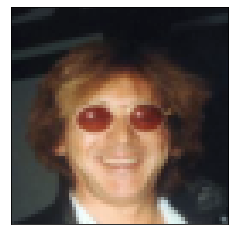

3


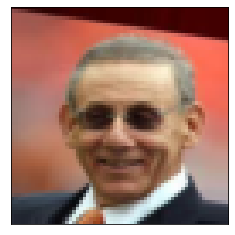

4


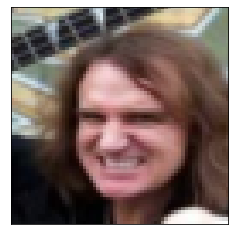

5


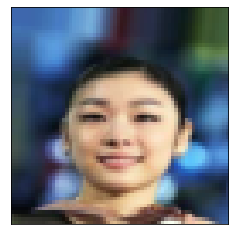

6


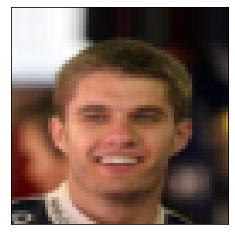

7


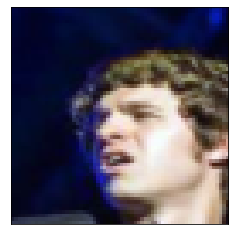

8


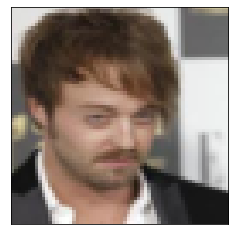

9


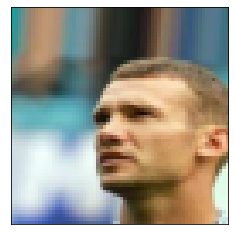

10


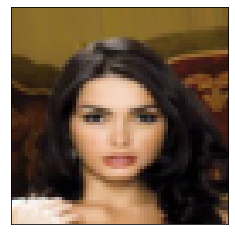

11


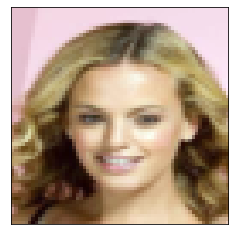

12


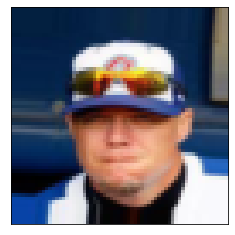

13


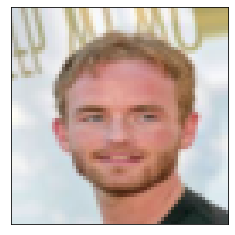

14


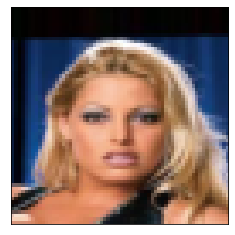

15


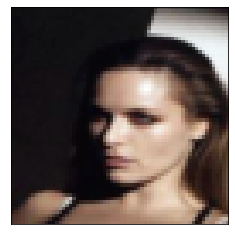

16


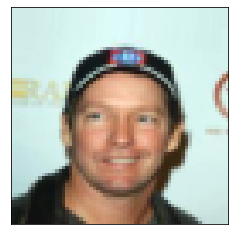

17


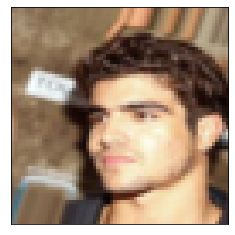

18


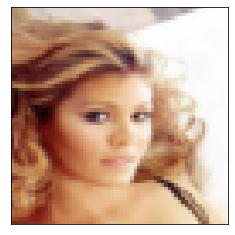

19


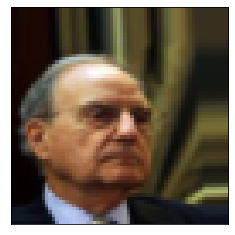

20


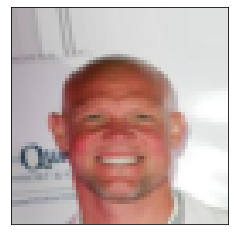

21


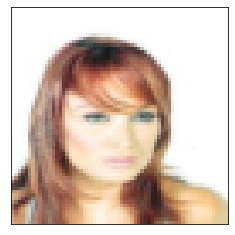

22


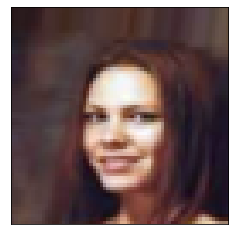

23


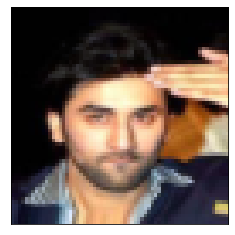

24


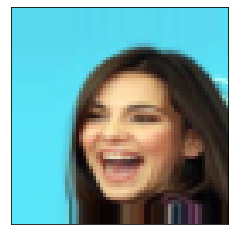

25


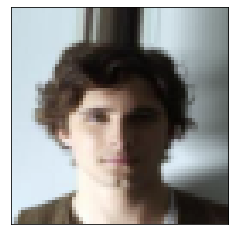

26


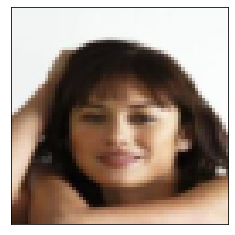

27


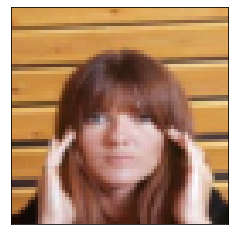

28


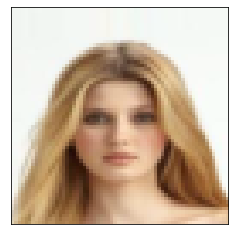

29


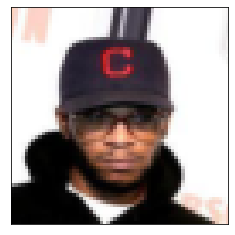

30


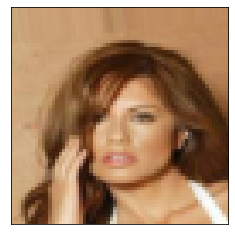

31


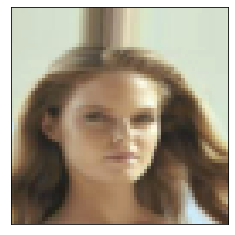

In [56]:
for b in range(32):
    print(b)
    show_image(x[b])

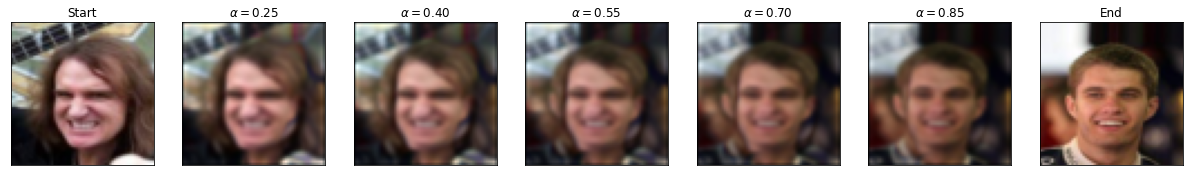

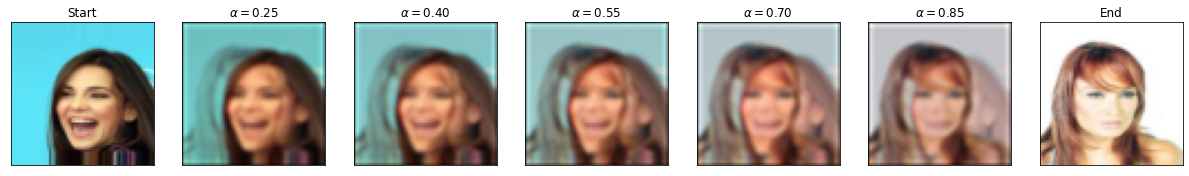

In [4]:
# example conv_was
for start_idx, target_idx in [(6,4), (21, 24)]:
    cw = ConvolutionalWasserstein2D(3, 64, gamma=1)
    pos_alphas = torch.arange(0.25, 1, 0.15)
    fig, ax = plt.subplots(1, len(pos_alphas)+2, figsize=((len(pos_alphas)+2)*3, 3))
    inp = x[[start_idx, target_idx]]
    show_image(inp[1,...], ax[0])
    ax[0].set_title(f"Start")
    show_image(inp[0, ...], ax[-1])
    ax[-1].set_title(f"End")
    ax[0].xaxis.set_visible(False); ax[0].yaxis.set_visible(False)
    ax[-1].xaxis.set_visible(False); ax[-1].yaxis.set_visible(False)

    with torch.no_grad():
        for i, alpha in enumerate(pos_alphas):
            alphas = torch.tensor([alpha, 1-alpha])
            fac = 0.3
            out = cw.wass_barycenter(inp, alphas, 10, entropic_args={'factor':fac})
            show_image(out, ax[i+1])
            ax[i+1].set_title(r'$\alpha = ${:.2f}'.format(alpha)) #(f"Alpha {alpha:.2}")
            ax[i+1].xaxis.set_visible(False)
            ax[i+1].yaxis.set_visible(False)
    plt.savefig('CelebA_convwas_example' + str(start_idx) + '_' + str(target_idx) + '.jpg')
    plt.show()


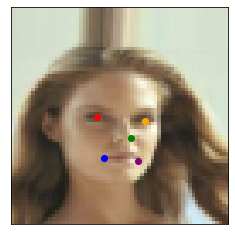

In [66]:
fig, ax = plt.subplots()
desired_output_dist = keypoints_to_input_masks(keypoints[:,31,:], input_R=None)
show_masks_on_image(x[31], desired_output_dist, ax, show_dist=False, show_max_points=True) #, cmaptouse='Greys')

Now, let's do it all WITH keypoints
max and min C tensor(7938) tensor(0)
max and min Ckeypoints tensor(236.) tensor(0.)
input_dist torch.Size([5, 3, 64, 64])
with keypoints tensor([0.2131, 0.2475, 0.1842, 0.1979, 0.2389]) tensor(0.2163)
input_dist torch.Size([5, 3, 64, 64])
without keypoints tensor([0.1374, 0.1562, 0.0000, 0.1356, 0.1476]) tensor(0.1154)


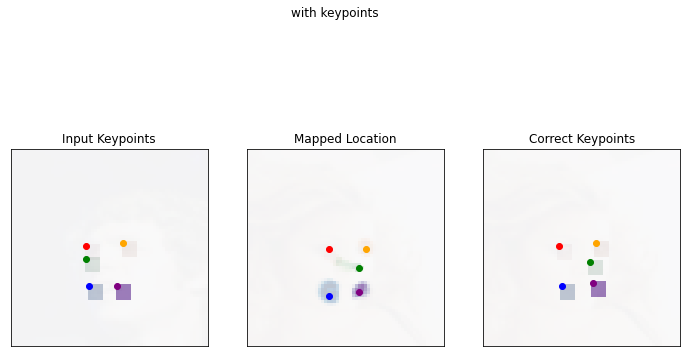

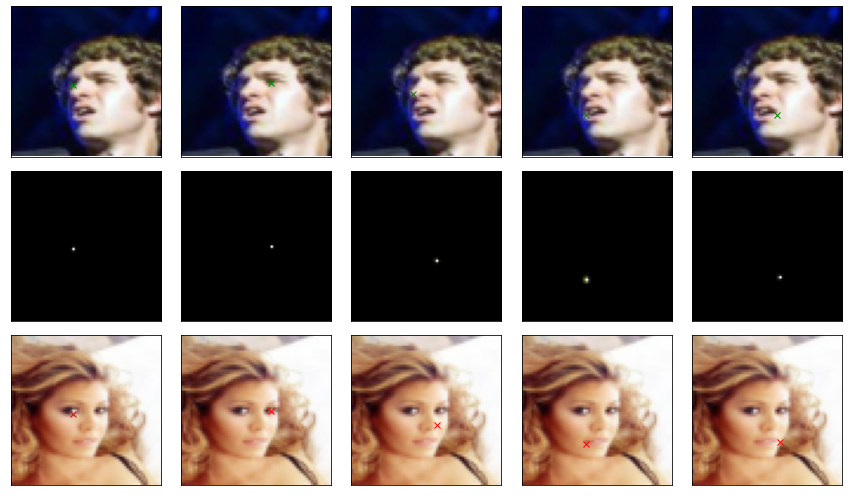

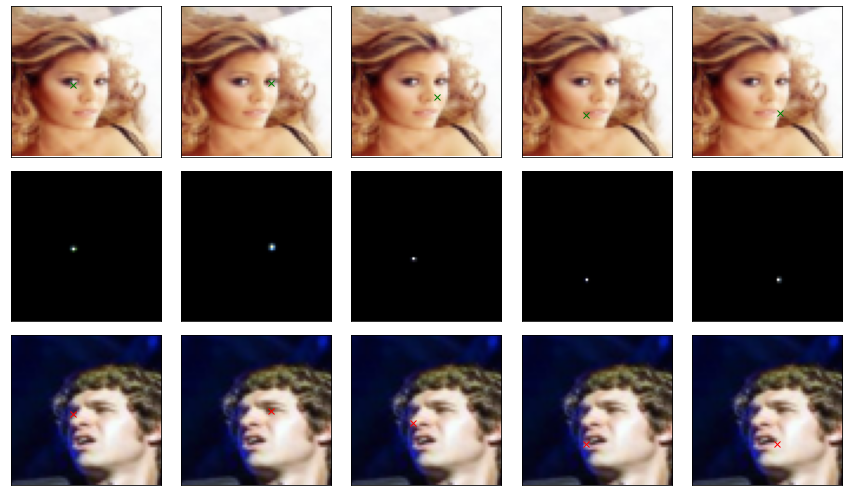

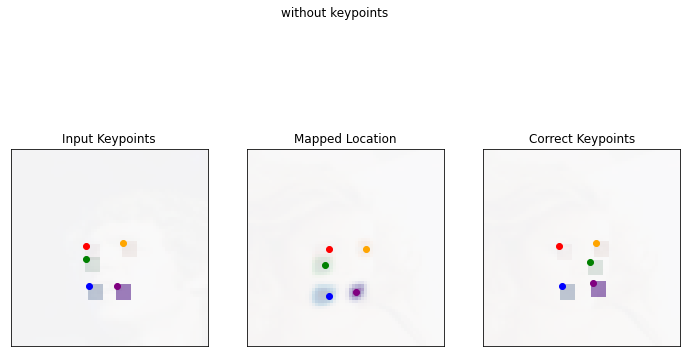

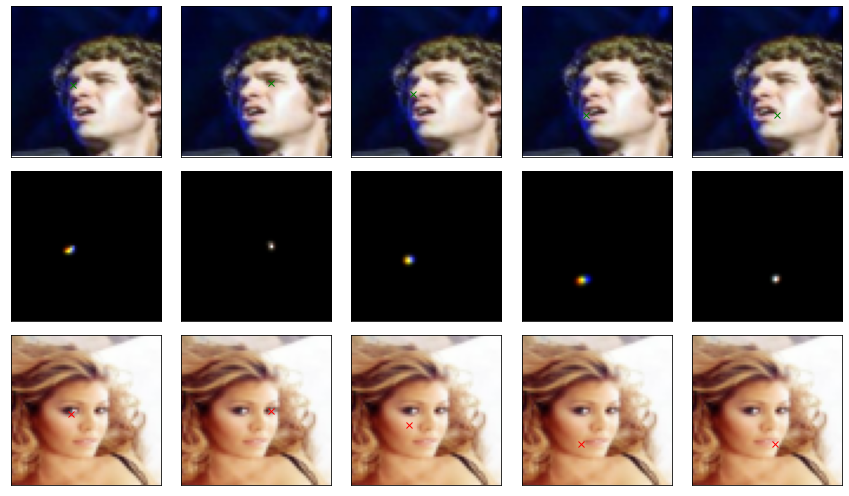

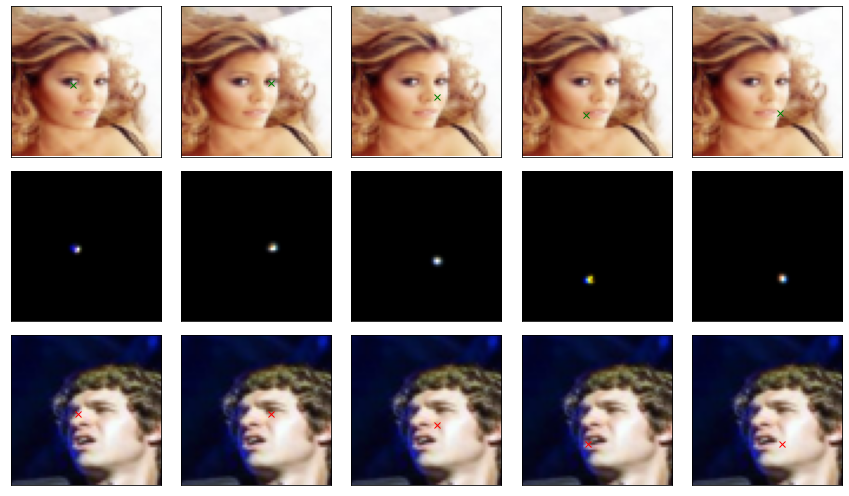

In [26]:
# Now let's try doing sinkhorn with/without keypoints
im1ind = 7 #7 #12 #1 #0 #28 #1
im2ind = 18 #5 #18 #14 #7 #5 #10
im1 = x[im1ind]
im2 = x[im2ind] #inp[1]
keypoints = get_img_landmarks(y)

def display_keypoints(im1, im2, keypoints, transport_plan):
    numkeypts = keypoints.shape[0]
    fig, axes = plt.subplots(3, numkeypts, figsize=(12, 7))
    for i in range(numkeypts):
        input_dist = torch.zeros(cw.a.shape)
        input_dist[0,:,keypoints[i, 0, 0], keypoints[i, 0, 1]] = 1
        show_image(im1, axes[0, i]) #.imshow(input_dist[0, 0, ...].cpu())
        axes[0,i].plot(keypoints[i, 0, 1], keypoints[i, 0, 0], marker="x", color="green") #markersize=3)
        axes[0,i].xaxis.set_visible(False); axes[0,i].yaxis.set_visible(False)
        
        output_dist_pre = transport_plan(input_dist)
        output_dist = output_dist_pre
        output_dist[torch.isnan(output_dist)] = 0
        show_image(output_dist[0,...], axes[1, i]) #
        axes[1,i].xaxis.set_visible(False); axes[1,i].yaxis.set_visible(False)
        
        show_image(im2, axes[2,i])
        smmed = torch.sum(torch.abs(output_dist[0, ...]),0) # added abs
        amx = torch.argmax(smmed)
        
        maxinds = unravel_index(amx, smmed.shape)
        axes[2,i].plot(maxinds[1], maxinds[0], marker="x", color="red") # should this be reversed???? yes!
        axes[2,i].xaxis.set_visible(False); axes[2,i].yaxis.set_visible(False)

metric = 'IOU'
normalize = True
    
# With keypoints
print('Now, let\'s do it all WITH keypoints')
keypoints_to_use = torch.stack((keypoints[:, im1ind, :],keypoints[:, im2ind, :]), dim=1)
rev_keypoints_to_use = torch.stack((keypoints[:, im2ind, :], keypoints[:, im1ind, :]), dim=1)
K, C, C_keypoints = make_K(2, 0.0001, R=10, matched_points=keypoints_to_use, numr=im1.shape[-2], numc=im1.shape[-1]) # R was 40
alpha = 8.2 #1.8
gamma = 2
print('max and min C', torch.max(C), torch.min(C))
print('max and min Ckeypoints', torch.max(C_keypoints), torch.min(C_keypoints))
K = torch.exp(-1 * (C + alpha*C_keypoints) / (2* gamma**2)) #torch.exp(-1 * (C_keypoints) / (2* gamma**2)) # # #
if normalize:
    K = normalize_K(K)
customH = lambda x:multiply_reshape(K, x)
customHT = lambda x:multiply_reshape(K.permute(2,3,0,1),x)
CWkeypts = ConvolutionalWasserstein2D(3, 64, gamma=1, customH=customH, customHT=customHT) # gamma was 1; should it be equal to other gamma?
kpobjvals, kpv, kpw=CWkeypts.sinkhorn(im1, im2, iters=10, return_plan=True) # all iters were 20: getting reasonable on 7/18
plank = lambda x: kpv*CWkeypts.H(kpw*x)
planTk = lambda x: kpw*CWkeypts.HT(kpv*x)

input_dist, output_dist = keypoints_to_output_masks(keypoints_to_use, planTk, input_R=5, out_thresh = 1e-6)
desired_output_dist = keypoints_to_input_masks(rev_keypoints_to_use, input_R=5)
fig, axes = plt.subplots(1, 3, figsize=(12, 7))
show_masks_on_image(im1, input_dist, axes[0], show_dist=True)
axes[0].set_title('Input Keypoints')
show_masks_on_image(im2, output_dist, axes[1], show_dist=True)
axes[1].set_title('Mapped Location')
show_masks_on_image(im2, desired_output_dist, axes[2], show_dist=True) #, cmaptouse='Greys')
axes[2].set_title('Correct Keypoints')
plt.suptitle('with keypoints')
distances = mapped_accuracy(output_dist, desired_output_dist, metric=metric)
print('with keypoints', distances, torch.mean(distances))

display_keypoints(im1, im2, keypoints_to_use[:, 0:1, :], planTk) #keypoints[:, im1ind:(im1ind+1)], planTk)
plt.tight_layout()
#plt.savefig('CelebA_full_WithKeypts1.pdf')
display_keypoints(im2, im1, rev_keypoints_to_use[:, 0:1, :], plank) #keypoints[:, im2ind:(im2ind+1), :], plank)
plt.tight_layout()
#plt.savefig('CelebA_full_WithKeypts2.pdf')

# Without keypoints
CW = ConvolutionalWasserstein2D(3, 64, gamma=1)
kpobjvals, kpv, kpw=CW.sinkhorn(im1, im2, iters=10, return_plan=True)
plan = lambda x: kpv*CW.H(kpw*x)
planT = lambda x: kpw*CW.HT(kpv*x)
# Visualize where each keypoint is sent

input_dist, output_dist = keypoints_to_output_masks(keypoints_to_use, planT, input_R=5, out_thresh = 1e-6)
desired_output_dist = keypoints_to_input_masks(rev_keypoints_to_use, input_R=5)
fig, axes = plt.subplots(1, 3, figsize=(12, 7))
show_masks_on_image(im1, input_dist, axes[0], show_dist=True)
axes[0].set_title('Input Keypoints')
show_masks_on_image(im2, output_dist, axes[1], show_dist=True)
axes[1].set_title('Mapped Location')
show_masks_on_image(im2, desired_output_dist, axes[2], show_max_points=True, show_dist=True) #, cmaptouse='Greys')
axes[2].set_title('Correct Keypoints')
plt.suptitle('without keypoints')
distances = mapped_accuracy(output_dist, desired_output_dist, metric=metric)
print('without keypoints', distances, torch.mean(distances))

display_keypoints(im1, im2, keypoints_to_use[:, 0:1, :], planT)
plt.tight_layout() 
#plt.savefig('CelebA_full_WithoutKeypts1.pdf')
display_keypoints(im2, im1, rev_keypoints_to_use[:, 0:1, :], plan)
plt.tight_layout() 
#plt.savefig('CelebA_full_WithoutKeypts2.pdf')

i 0
input_dist torch.Size([5, 3, 64, 64])
with keypoints tensor([0.2219, 0.2206, 0.2419, 0.2246, 0.2259]) tensor(0.2270)


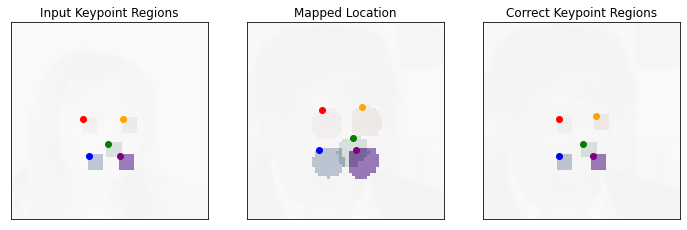

input_dist torch.Size([5, 3, 64, 64])
input_dist torch.Size([5, 3, 64, 64])
without keypoints tensor([0.1429, 0.1462, 0.1440, 0.1415, 0.1412]) tensor(0.1432)


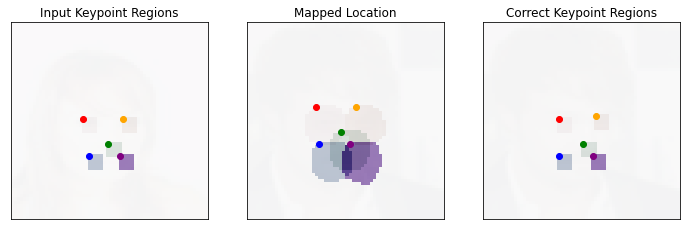

input_dist torch.Size([5, 3, 64, 64])
i 1
input_dist torch.Size([5, 3, 64, 64])
with keypoints tensor([0.2467, 0.2525, 0.2193, 0.2246, 0.2055]) tensor(0.2297)


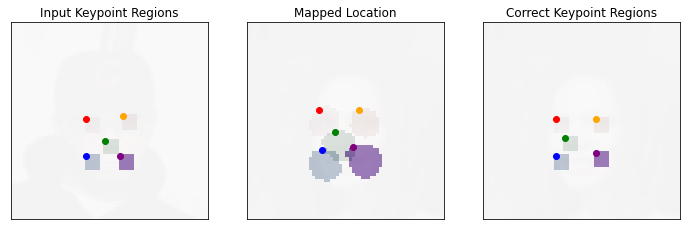

input_dist torch.Size([5, 3, 64, 64])
input_dist torch.Size([5, 3, 64, 64])
without keypoints tensor([0.1685, 0.1812, 0.1289, 0.1491, 0.1415]) tensor(0.1538)


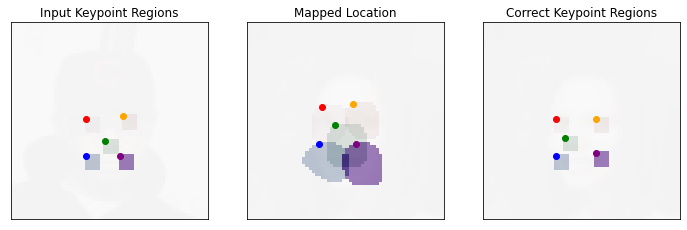

input_dist torch.Size([5, 3, 64, 64])
i 2
input_dist torch.Size([5, 3, 64, 64])
with keypoints tensor([0.2239, 0.2246, 0.2419, 0.2273, 0.2329]) tensor(0.2301)


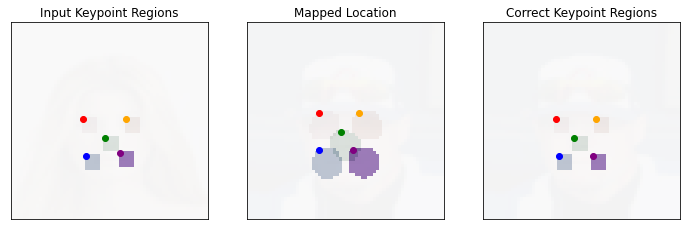

input_dist torch.Size([5, 3, 64, 64])
input_dist torch.Size([5, 3, 64, 64])
without keypoints tensor([0.1479, 0.1485, 0.1521, 0.1531, 0.1445]) tensor(0.1492)


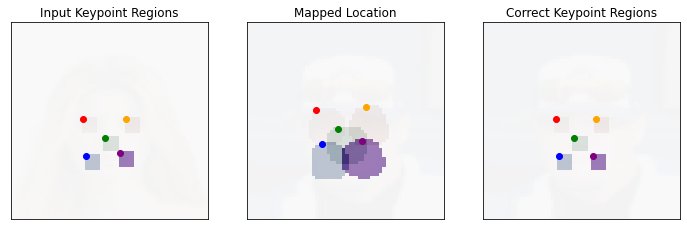

input_dist torch.Size([5, 3, 64, 64])
i 3
input_dist torch.Size([5, 3, 64, 64])
with keypoints tensor([0.2226, 0.2137, 0.2396, 0.2180, 0.2131]) tensor(0.2214)


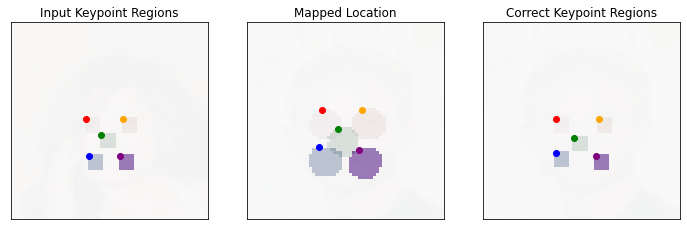

input_dist torch.Size([5, 3, 64, 64])
input_dist torch.Size([5, 3, 64, 64])
without keypoints tensor([0.1479, 0.1394, 0.1437, 0.1379, 0.1453]) tensor(0.1428)


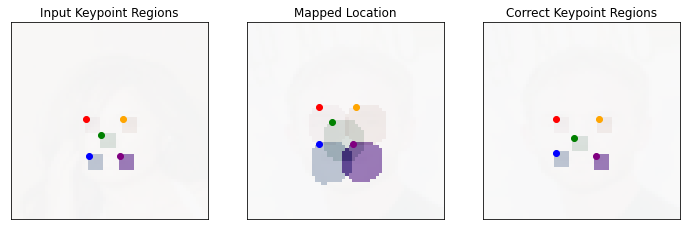

input_dist torch.Size([5, 3, 64, 64])
i 4
input_dist torch.Size([5, 3, 64, 64])
with keypoints tensor([0.2143, 0.2389, 0.1583, 0.2149, 0.2300]) tensor(0.2113)


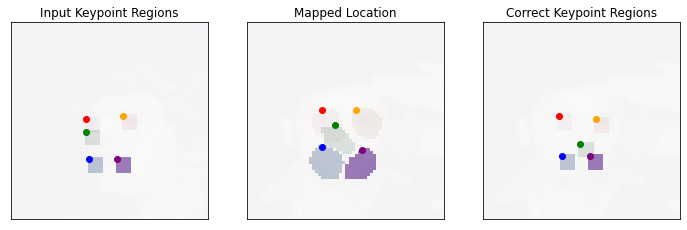

input_dist torch.Size([5, 3, 64, 64])
input_dist torch.Size([5, 3, 64, 64])
without keypoints tensor([0.1369, 0.1534, 0.0080, 0.1342, 0.1391]) tensor(0.1143)


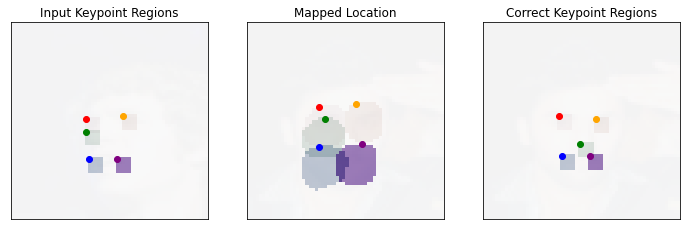

input_dist torch.Size([5, 3, 64, 64])


In [27]:
# With/without keypoints for many pairs!!!

numtrials = 5 #100
counter = 0
normalize = True
IOUs_keypoints = []
l2dists_keypoints = []
IOUs = []
l2dists = []
for i in range(numtrials):
    print('i', i)
    im1ind = np.random.randint(y.shape[0]) #7 #12 #1 #0 #28 #1
    im2ind = np.random.randint(y.shape[0]) #5 #18 #14 #7 #5 #10
    dofigssmall = True
    dofigslarge = False
    if im1ind != im2ind:
        counter += 1
        im1 = x[im1ind]
        im2 = x[im2ind] #inp[1]
        keypoints = get_img_landmarks(y)      

        # With keypoints
        keypoints_to_use = torch.stack((keypoints[:, im1ind, :],keypoints[:, im2ind, :]), dim=1)
        rev_keypoints_to_use = torch.stack((keypoints[:, im2ind, :], keypoints[:, im1ind, :]), dim=1)
        K, C, C_keypoints = make_K(2, 0.0001, R=10, matched_points=keypoints_to_use, numr=im1.shape[-2], numc=im1.shape[-1]) # R was 40
        alpha = 8.2 #1.8
        gamma = 2
        K = torch.exp(-1 * (C + alpha*C_keypoints) / (2* gamma**2)) #torch.exp(-1 * (C_keypoints) / (2* gamma**2)) # # #
        if normalize:
            K = normalize_K(K)
        customH = lambda x:multiply_reshape(K, x)
        customHT = lambda x:multiply_reshape(K.permute(2,3,0,1),x)
        CWkeypts = ConvolutionalWasserstein2D(3, 64, gamma=1, customH=customH, customHT=customHT) # gamma was 1; should it be equal to other gamma?
        kpobjvals, kpv, kpw=CWkeypts.sinkhorn(im1, im2, iters=10, return_plan=True) # all iters were 20: getting reasonable on 7/18
        plank = lambda x: kpv*CWkeypts.H(kpw*x)
        planTk = lambda x: kpw*CWkeypts.HT(kpv*x)

        input_dist, output_dist = keypoints_to_output_masks(keypoints_to_use, planTk, input_R=5, out_thresh = 1e-6)
        desired_output_dist = keypoints_to_input_masks(rev_keypoints_to_use, input_R=5)
        distances = mapped_accuracy(output_dist, desired_output_dist, metric='IOU')
        IOUs_keypoints.append(torch.mean(distances))
        print('with keypoints', distances, torch.mean(distances))
        
        if dofigssmall:
            fig, axes = plt.subplots(1, 3, figsize=(12, 7))
            show_masks_on_image(im1, input_dist, axes[0], show_dist=True, show_max_points=True)
            axes[0].set_title('Input Keypoint Regions')
            show_masks_on_image(im2, output_dist, axes[1], show_dist=True, show_max_points=True)
            axes[1].set_title('Mapped Location')
            show_masks_on_image(im2, desired_output_dist, axes[2], show_dist=True, show_max_points=True) #, cmaptouse='Greys')
            axes[2].set_title('Correct Keypoint Regions')
            #fig.savefig('IOUVis_' + str(i) + 'Keypoints.pdf')
            plt.show()
        
        input_dist, output_dist = keypoints_to_output_masks(keypoints_to_use, planTk) #, input_R=5, out_thresh = 1e-6)
        desired_output_dist = keypoints_to_input_masks(rev_keypoints_to_use) #, input_R=5)
        distances = mapped_accuracy(output_dist, desired_output_dist, metric='dist')
        l2dists_keypoints.append(torch.mean(distances))
        
        
        if dofigslarge:
            display_keypoints(im1, im2, keypoints_to_use[:, 0:1, :], planTk) #keypoints[:, im1ind:(im1ind+1)], planTk)
            plt.tight_layout()
            display_keypoints(im2, im1, rev_keypoints_to_use[:, 0:1, :], plank) #keypoints[:, im2ind:(im2ind+1), :], plank)
            plt.tight_layout()

        # Without keypoints
        CW = ConvolutionalWasserstein2D(3, 64, gamma=1)
        kpobjvals, kpv, kpw=CW.sinkhorn(im1, im2, iters=10, return_plan=True)
        plan = lambda x: kpv*CW.H(kpw*x)
        planT = lambda x: kpw*CW.HT(kpv*x)
        # Visualize where each keypoint is sent
        
        input_dist, output_dist = keypoints_to_output_masks(keypoints_to_use, planT, input_R=5, out_thresh = 1e-6)
        desired_output_dist = keypoints_to_input_masks(rev_keypoints_to_use, input_R=5)
        distances = mapped_accuracy(output_dist, desired_output_dist, metric='IOU')
        IOUs.append(torch.mean(distances))
        print('without keypoints', distances, torch.mean(distances))
        
        if dofigssmall:
            fig, axes = plt.subplots(1, 3, figsize=(12, 7))
            show_masks_on_image(im1, input_dist, axes[0], show_dist=True, show_max_points=True)
            axes[0].set_title('Input Keypoint Regions')
            show_masks_on_image(im2, output_dist, axes[1], show_dist=True, show_max_points=True)
            axes[1].set_title('Mapped Location')
            show_masks_on_image(im2, desired_output_dist, axes[2], show_max_points=True, show_dist=True) #, cmaptouse='Greys')
            axes[2].set_title('Correct Keypoint Regions')
            #fig.savefig('IOUVis_' + str(i) + 'NoKeypoints.pdf')
            plt.show()
        
        input_dist, output_dist = keypoints_to_output_masks(keypoints_to_use, planT) #, input_R=5, out_thresh = 1e-6)
        desired_output_dist = keypoints_to_input_masks(rev_keypoints_to_use) #, input_R=5)
        distances = mapped_accuracy(output_dist, desired_output_dist, metric='dist')
        l2dists.append(torch.mean(distances))
        
        if dofigslarge: 
            display_keypoints(im1, im2, keypoints_to_use[:, 0:1, :], planT)
            plt.tight_layout() 
            display_keypoints(im2, im1, rev_keypoints_to_use[:, 0:1, :], plan)
            plt.tight_layout() 






In [7]:
print('IOU keypoints', torch.mean(torch.tensor(IOUs_keypoints)), 'IOU without', torch.mean(torch.tensor(IOUs)))
print('dist keypoints', torch.mean(torch.tensor(l2dists_keypoints)), 'dist without', torch.mean(torch.tensor(l2dists)))

496

tensor([[[10, 40],
         [50, 10]],

        [[10, 10],
         [50, 40]]])


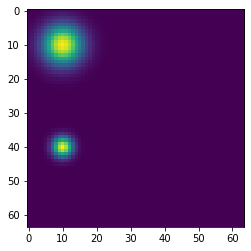

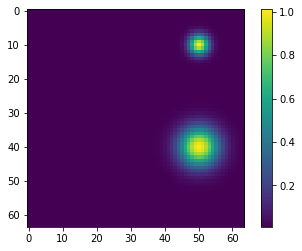

In [13]:
# Fake example for barycenters: two gaussians, slightly different variances, different centers
grid = np.linspace(0, 63, 64)
X, Y = np.meshgrid(grid, grid)
X, Y = torch.tensor(X).float(), torch.tensor(Y).float()
coordcenters = torch.tensor([[[10, 40], [50, 10]], [[10, 10], [50, 40]]]) #torch.tensor([[[32, 40], [32, 10]], [[32, 10], [32, 40]]]) #
sigma = 4;
sigma2 = 2 #1 # just for making sure the keypoints are sufficiently confusing
print(coordcenters)
mat = torch.exp(-1*((X-coordcenters[0,0,0])**2 + (Y-coordcenters[0,0,1])**2) / (2 * sigma2**2)) + torch.exp(-1*((X-coordcenters[1,0,0])**2 + (Y-coordcenters[1,0,1])**2) / (2 * sigma**2))
mat2 = torch.exp(-1*((X-coordcenters[0,1,0])**2 + (Y-coordcenters[0,1,1])**2) / (2 * sigma2**2)) + torch.exp(-1*((X-coordcenters[1,1,0])**2 + (Y-coordcenters[1,1,1])**2) / (2 * sigma**2))
mat += 1e-2
mat2 += 1e-2
plt.imshow(mat)
plt.show()
plt.imshow(mat2)
plt.colorbar()
keypoints_gaussian = torch.stack((coordcenters[..., 1], coordcenters[..., 0]),-1) #torch.tensor([[[40, 10], [10, 50]], [[10, 10], [40, 50]]]) #.unsqueeze(0)

input_dist torch.Size([2, 3, 64, 64])
input_dist torch.Size([2, 3, 64, 64])
input_dist torch.Size([2, 3, 64, 64])
input_dist torch.Size([2, 3, 64, 64])
input_dist torch.Size([2, 3, 64, 64])


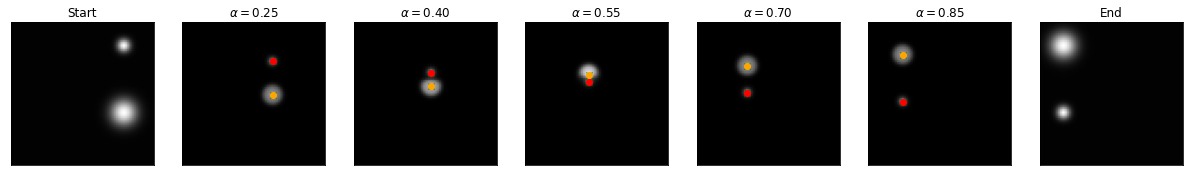

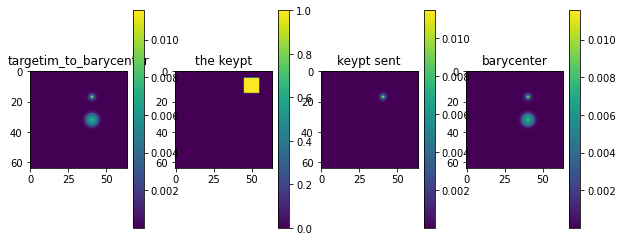

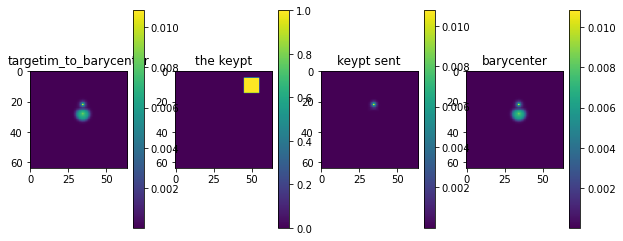

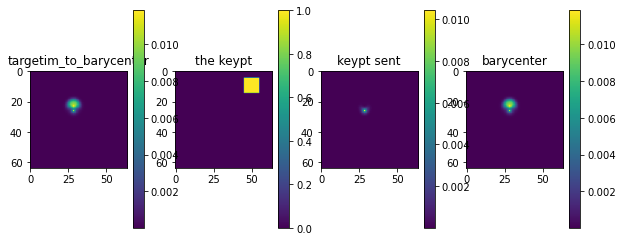

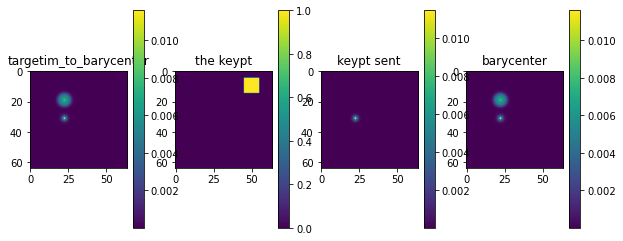

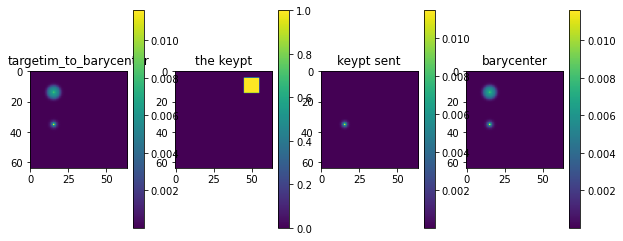

In [28]:
# Barycenters with keypoints
allimginds = [7, 18] #, 20]
basekeypointsind = allimginds[0]
otherind = allimginds[1]
alphakeypoints = 0.7 #0.7 #0.2 #1.8
gamma = 2
gammaforcost = 2
cw = ConvolutionalWasserstein2D(3, 64, gamma=gamma)
normalize=True
inp = x[allimginds]
keypoints = get_img_landmarks(y)


fakeexample = True
if fakeexample:
    allimginds = [0, 1]
    if len(mat.shape) < 3:
        mat=mat.unsqueeze(0)
        mat2=mat2.unsqueeze(0)
    mat = normalize_im(mat)
    mat2 = normalize_im(mat2 )
    inp = torch.cat((mat.repeat(1,3,1,1), mat2.repeat(1,3,1,1)), dim=0) #/ 1e4
    keypoints = keypoints_gaussian
    
img1 = inp[1,...] # target
img0 = inp[0,...] # start

for start_idx, target_idx in [allimginds]: #[(6,4), (21, 24)]: #1)
    pos_alphas = torch.arange(0.25, 1, 0.15) #torch.tensor([0.001,0.33, 0.66,0.999]) #
    fig0, ax = plt.subplots(1, len(pos_alphas)+2, figsize=((len(pos_alphas)+2)*3, 3))
    
    show_image(img1, ax[0])
    ax[0].set_title(f"Start")
    show_image(img0, ax[-1])
    ax[-1].set_title(f"End")
    ax[0].xaxis.set_visible(False); ax[0].yaxis.set_visible(False)
    ax[-1].xaxis.set_visible(False); ax[-1].yaxis.set_visible(False)

    with torch.no_grad():
        for i, alpha in enumerate(pos_alphas):
            alphas = torch.tensor([alpha, 1-alpha])
            
            allKs = []
            keypoints_for_barycenter = (alphas[0]*keypoints[:, start_idx, :] + alphas[1]*keypoints[:, target_idx, :]).int()
            for idx, imgind in enumerate(allimginds):
                keypoints_to_use = torch.stack((keypoints_for_barycenter,keypoints[:, imgind, :]), dim=1)
                K, C, C_keypoints = make_K(gamma=2, alpha=0.0001, R=10, matched_points=keypoints_to_use, numr=64, numc=64, normalize=True) # R was 10 for gaussians to work!
                K = torch.exp(-1 * (C_keypoints) / (2* gamma**2)) #torch.exp(-1 * (((1-alphakeypoints)*C / (2*gammaforcost**2)) + ((alphakeypoints*C_keypoints) / (2* gamma**2))))  ## # #
                if normalize:
                    K = normalize_K(K)
                allKs.append(K)
            barycenterK = torch.stack(allKs, dim=0)
            barycenterKT = barycenterK.permute(0, 3, 4, 1, 2)
            barycenterH = lambda x:multiply_reshape(barycenterK, x)
            barycenterHT = lambda x:multiply_reshape(barycenterKT, x)
            
            fac = 0.3 #3 # 0.3 for gaussian example to work
            out, v, w = cw.wass_barycenter(inp, alphas, 10, verbose=False, return_plan=True, H_all=barycenterH, HT_all=barycenterHT, entropic_args={'factor':fac})
            show_image(out, ax[i+1])
            for kind in range(keypoints.shape[0]):
                ax[i+1].plot(keypoints_for_barycenter[kind, 1], keypoints_for_barycenter[kind, 0], color='green', marker='x')
            
            def outplan(x):
                # input x has 2 batch channels because there are two keypoints!
                # barycenterK has 2 batch channels because interpolating between two images
                # w and v have 2 batch channels because interpolating between two images
                wx = w[1:,...].repeat(x.shape[0], 1, 1, 1) * x;
                intermed = multiply_reshape(barycenterK[1:, ...].repeat(wx.shape[0],1,1,1,1), wx) # 
                res = v[1:, ...] * intermed
                return res
            
            fig, tax = plt.subplots(1,4, figsize=(10,4))
            targetim_to_barycenter = outplan(cw.a) #inp[target_idx:target_idx+1,...])
            im=tax[0].imshow(targetim_to_barycenter[0,0,...])
            tax[0].set_title('targetim_to_barycenter')
            fig.colorbar(im, ax=tax[0])
            
            kplan = box_around_point((1,3,64,64), keypoints[0, target_idx, 0], keypoints[0, target_idx, 1], input_R=10) #torch.zeros(1,3,64,64)
            keypt_to_barycenter = outplan(kplan)
            im=tax[1].imshow(kplan[0,0, ...])
            fig.colorbar(im, ax=tax[1])
            tax[1].set_title('the keypt')
            im=tax[2].imshow(keypt_to_barycenter[0,0,...])
            tax[2].set_title('keypt sent')
            fig.colorbar(im, ax=tax[2])
            
            im=tax[3].imshow(out[0,...])
            tax[3].set_title('barycenter')
            fig.colorbar(im, ax=tax[3])
            
            
            input_dist, output_dist = keypoints_to_output_masks(keypoints[:, target_idx, :], outplan, input_R=None, numchannels=3, numrow=64, numcol=64) #, out_thresh = 1e-6)
            desired_output_dist = keypoints_to_input_masks(keypoints[:, start_idx, :])
            show_masks_on_image(None, output_dist, ax[i+1], show_max_points=True, show_dist=False)
            
            ax[i+1].set_title(r'$\alpha = ${:.2f}'.format(alpha)) #(f"Alpha {alpha:.2}")
            ax[i+1].xaxis.set_visible(False)
            ax[i+1].yaxis.set_visible(False)
    #fig0.savefig('CelebA_barycenter_keypoints' + str(start_idx) + '_' + str(target_idx) + '.pdf')
    plt.show()

In [24]:
torch.norm(v)

tensor(nan)

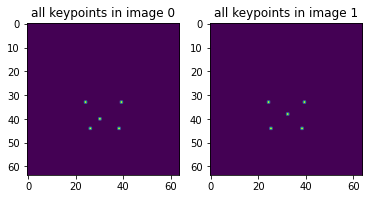

Now, let's do it all WITH keypoints
keypoints_to_use torch.Size([5, 2, 2])


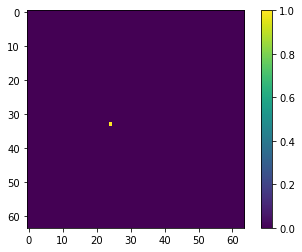

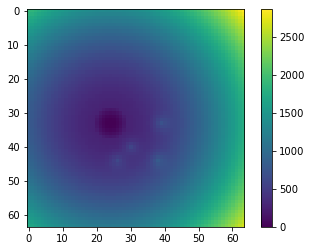

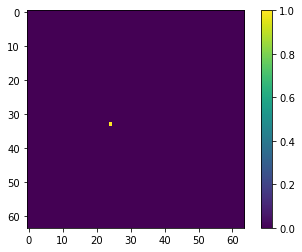

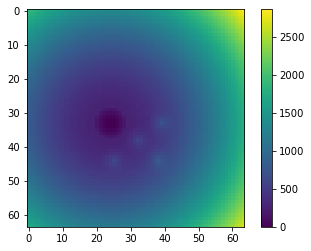

In [80]:
# Test the cost matrix
im1ind = 28 #1
im2ind = 10
im1 = x[im1ind]
im2 = x[im2ind] #inp[1]

keypoints_to_use = torch.stack((keypoints[:, im1ind, :],keypoints[:, im2ind, :]), dim=1)
plt.figure()
allkeypts0=torch.zeros(im1[0,...].shape)
allkeypts1=torch.zeros(im1[0,...].shape)
for i in range(keypoints_to_use.shape[0]):
    allkeypts0[keypoints_to_use[i, 0, 0],keypoints_to_use[i, 0, 1]] = 1
    allkeypts1[keypoints_to_use[i, 1, 0],keypoints_to_use[i, 1, 1]] = 1
plt.subplot(121)
plt.imshow(allkeypts0.cpu())
plt.title('all keypoints in image 0')
plt.subplot(122)
plt.imshow(allkeypts1.cpu())
plt.title('all keypoints in image 1')
plt.show()

# With keypoints
print('Now, let\'s do it all WITH keypoints')

print('keypoints_to_use', keypoints_to_use.shape)
K, C, C_keypoints = make_K(2, 0.0001, 5, keypoints_to_use, numr=im1.shape[-2], numc=im1.shape[-1])

Capply = C+ alpha*C_keypoints

tempx = torch.zeros(32,3,64,64)
tempx[:,:,keypoints_to_use[0,1,0], keypoints_to_use[0,1,1]] = 1
out=multiply_reshape(Capply,tempx)
plt.imshow(tempx[0,0,...].cpu())
plt.colorbar()
plt.show()
plt.imshow(out[0,0,...].cpu())
plt.colorbar()
plt.show()

tempx = torch.zeros(32,3,64,64)
tempx[:,:,keypoints_to_use[0,0,0], keypoints_to_use[0,0,1]] = 1
out=multiply_reshape(Capply.permute(2,3,0,1),tempx)
plt.imshow(tempx[0,0,...].cpu())
plt.colorbar()
plt.show()
plt.imshow(out[0,0,...].cpu())
plt.colorbar()
plt.show()


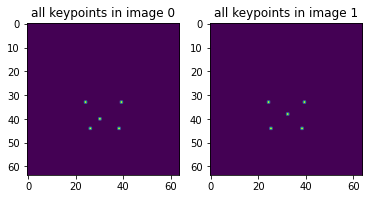

Now, let's do it all WITH keypoints
keypoints_to_use torch.Size([5, 2, 2])


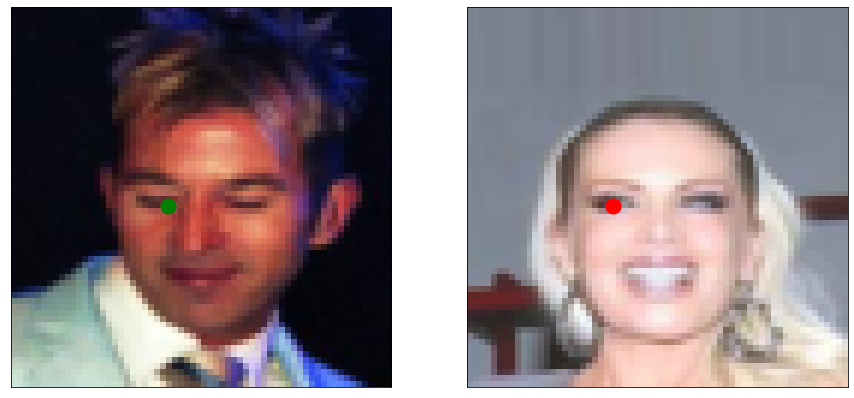

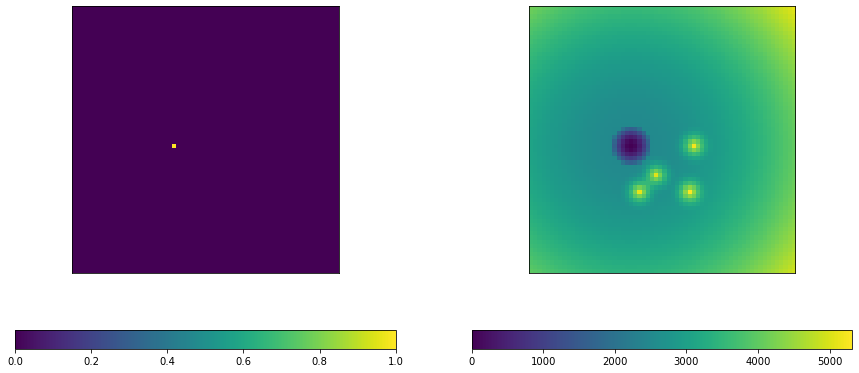

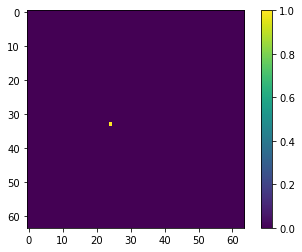

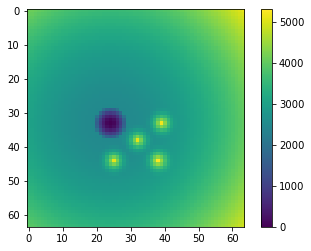

In [104]:
# Cost matrix application figure

# Test the cost matrix
im1ind = 28 #1
im2ind = 10
im1 = x[im1ind]
im2 = x[im2ind] #inp[1]


keypoints_to_use = torch.stack((keypoints[:, im1ind, :],keypoints[:, im2ind, :]), dim=1)
#keypoints_to_use = keypoints_to_use[0:2, ...]
plt.figure()
allkeypts0=torch.zeros(im1[0,...].shape)
allkeypts1=torch.zeros(im1[0,...].shape)
for i in range(keypoints_to_use.shape[0]):
    allkeypts0[keypoints_to_use[i, 0, 0],keypoints_to_use[i, 0, 1]] = 1
    allkeypts1[keypoints_to_use[i, 1, 0],keypoints_to_use[i, 1, 1]] = 1
plt.subplot(121)
plt.imshow(allkeypts0.cpu())
plt.title('all keypoints in image 0')
plt.subplot(122)
plt.imshow(allkeypts1.cpu())
plt.title('all keypoints in image 1')
plt.show()

# With keypoints
print('Now, let\'s do it all WITH keypoints')

K, C, C_keypoints = make_K(2, 0.0001, 5, keypoints_to_use, numr=im1.shape[-2], numc=im1.shape[-1])

alpha = 100
Capply = C+ alpha*C_keypoints

tempx = torch.zeros(32,3,64,64)
tempx[:,:,keypoints_to_use[0,1,0], keypoints_to_use[0,1,1]] = 1
out=multiply_reshape(Capply,tempx)
fig = plt.figure(figsize=(15,7))
ax=plt.subplot(121)
show_image(im1,ax)
ax.plot(keypoints[0, 1, 1], keypoints[0, 1, 0], marker="o", color="green", markersize=15)

ax=plt.subplot(122)
show_image(im2,ax)
ax.plot(keypoints[0, 0, 1], keypoints[0, 0, 0], marker="o", color="red", markersize=15)

#plt.savefig('CelebA_Cfig_keypts.pdf')

fig = plt.figure(figsize=(15,7))
ax=plt.subplot(121)
plt.imshow(tempx[0,0,...].cpu())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.colorbar(orientation='horizontal')

ax = plt.subplot(122)
plt.imshow(out[0,0,...].cpu())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.colorbar(orientation='horizontal')
plt.show()

#plt.savefig('CelebA_Cfig_matrix.pdf')

tempx = torch.zeros(32,3,64,64)
tempx[:,:,keypoints_to_use[0,0,0], keypoints_to_use[0,0,1]] = 1
out=multiply_reshape(Capply.permute(2,3,0,1),tempx)
plt.imshow(tempx[0,0,...].cpu())
plt.colorbar()
plt.show()
plt.imshow(out[0,0,...].cpu())
plt.colorbar()
plt.show()

